## OntoUML templating

In [10]:
import os
import pandas as pd
import yaml


def extract_csv_from_ontouml_models(models_dir, output_csv):
    # CSV header with the desired columns
    header = [
        'key',
        'title',
        'keywords',
        'theme',
        'ontologyType',
        'designedForTask',
        'language',
        'context',
        'source'
    ]

    rows = []

    # Iterate over each folder in the models directory
    for folder in os.listdir(models_dir):
        folder_path = os.path.join(models_dir, folder)
        if os.path.isdir(folder_path):
            metadata_path = os.path.join(folder_path, 'metadata.yaml')
            if os.path.isfile(metadata_path):
                with open(metadata_path, 'r', encoding='utf-8') as f:
                    try:
                        data = yaml.safe_load(f)
                    except Exception as e:
                        print(f"Error reading YAML file {metadata_path}: {e}")
                        data = {}
                
                # Retrieve each value; if the key doesn't exist, default to an empty string
                title = data.get('title', '')
                keywords = data.get('keywords', '')
                # Convert keywords to a string if it's a list
                if isinstance(keywords, list):
                    keywords = ', '.join(keywords)
                else:
                    keywords = str(keywords)
                theme = data.get('theme', '')
                ontologyType = data.get('ontologyType', '')
                designedForTask = data.get('designedForTask', '')
                language = data.get('language', '')
                context = data.get('context', '')
                source = data.get('source', '')
                
                rows.append([
                    folder,
                    title,
                    keywords,
                    theme,
                    ontologyType,
                    designedForTask,
                    language,
                    context,
                    source
                ])
            else:
                print(f"metadata.yaml not found in {folder_path}, skipping folder.")

    pd.DataFrame(rows, columns=header).to_csv(output_csv, index=False, encoding='utf-8')
    print(f"CSV file '{output_csv}' has been created with {len(rows)} records.")


In [11]:
import os
import json
import csv
import ast

def sanitize_text(text):
    """Remove newlines and extra spaces from a text value."""
    if isinstance(text, str):
        return text.replace("\n", " ").strip()
    return text

def camel_or_snake_to_title(name):
    """Convert camelCase or snake_case to Title Case, preserving all-uppercase abbreviations and avoiding extra spaces."""
    if not name:
        return ""
    
    # Handle snake_case
    if '_' in name:
        parts = name.split('_')
    else:
        # Handle camelCase and abbreviations
        parts = []
        current_part = ''
        for _, char in enumerate(name):
            if char.isupper():
                # If current_part is not empty and the previous char is lowercase, start a new part
                if current_part and not current_part[-1].isupper():
                    parts.append(current_part)
                    current_part = char
                else:
                    current_part += char
            else:
                # If previous was all uppercase and next is lowercase, split (for cases like 'RDBMSCopy')
                if len(current_part) > 1 and current_part.isupper():
                    parts.append(current_part)
                    current_part = char
                else:
                    current_part += char
        if current_part:
            parts.append(current_part)
    
    # Remove any accidental empty strings
    parts = [p for p in parts if p]
    
    # Capitalize only non-all-uppercase parts, preserve abbreviations
    def smart_cap(part):
        return part if part.isupper() else part.capitalize()
    
    return sanitize_text(' '.join(smart_cap(part) for part in parts))



def read_json_file(json_path):
    """Attempt to load a JSON file using UTF-8 and fallback to Latin-1 if needed."""
    # print(f"Reading JSON file: {json_path}")
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except UnicodeDecodeError as e:
        # print(f"UTF-8 decode error: {e}, trying latin-1...")
        with open(json_path, 'r', encoding='latin-1') as f:
            data = json.load(f)
        # print(f"Successfully read JSON file with latin-1 encoding: {json_path}")
        return data

def add_element_ids(data, id_map):
    """Recursively add element ids to each term and property in the JSON structure."""
    if isinstance(data, dict):
        if 'id' in data and len(data) > 2: 
            id_map[data['id']] = data
        for _, value in data.items():
            if isinstance(value, (dict, list)):
                add_element_ids(value, id_map)
    elif isinstance(data, list):
        for item in data:
            add_element_ids(item, id_map)

In [12]:
from tqdm.auto import tqdm
from typing import Union, Literal


def get_all_ontouml_type_properties(node, s):
    ignore_types = [
        'PackageView', 
        'GeneralizationSetView', 
        'ClassView', 
        'Diagram', 
        'RelationView', 
        'GeneralizationSetView', 
        'Path', 
        'Rectangle', 
        'Text'
    ]
    exclude_properties = [
        'id', 
        'name', 
        'description', 
        'propertyType', 
        'general', 
        'specific', 
        'modelElement', 
        'source', 
        'target'
    ]
    if 'type' in node and node['type'] not in ignore_types:
        node_type = node['type']
        if node_type not in s:
            s[node_type] = dict()
        
        for k, v in node.items():
            if k not in s[node_type]:
                s[node_type][k] = set()
            if k not in exclude_properties and \
                (
                    isinstance(v, (str, int, float, bool)) or \
                    (isinstance(v, list) and all(isinstance(i, (str, int, float, bool)) for i in v)) or \
                    (isinstance(v, dict) and all(isinstance(i, (str, int, float, bool)) for i in v.values()))
                ):
                if isinstance(v, list):
                    for item in v:
                        s[node_type][k].add(item)
                elif isinstance(v, dict):
                    for item in v.values():
                        s[node_type][k].add(item)
                else:
                    s[node_type][k].add(v)
                
    for _, v in node.items():
        if isinstance(v, dict):
            get_all_ontouml_type_properties(v, s)
        elif isinstance(v, list):
            for item in v:
                if isinstance(item, dict):
                    get_all_ontouml_type_properties(item, s)


def set_ontouml_schema(models_dir, schema):
    for folder in tqdm(os.listdir(models_dir)):
        folder_path = os.path.join(models_dir, folder)
        if os.path.isdir(folder_path):
            json_file = os.path.join(folder_path, "ontology.json")
            if os.path.exists(json_file):
                data = read_json_file(json_file)
                get_all_ontouml_type_properties(data, schema)

def get_relation_str(kwargs):
    relation_name = " with a connection named " + kwargs.get('name', '') if kwargs.get('name', '') else ""
    id_map = kwargs.get('id_map')
    properties = kwargs.get('properties', [])
    source_id = properties[0]['id'] if properties and 'id' in properties[0] else None
    target_id = properties[1]['id'] if len(properties) > 1 and 'id' in properties[1] else None
    if source_id is None or target_id is None:
        raise ValueError(f"Source or target id not found in properties: properties={properties}")
    if source_id not in kwargs['id_map'] or target_id not in kwargs['id_map']:
        raise ValueError(f"Source or target id not found in id_map: source_id={source_id}, target_id={target_id}")
    source_property_node, target_property_node = id_map[properties[0]['id']], id_map[properties[0]['id']]
    try:
        assert source_property_node is not None, f"source_property_node is None for id {properties[0]['id']}"
        assert target_property_node is not None, f"target_property_node is None for id {properties[1]['id']}"
        assert 'propertyType' in source_property_node, f"propertyType not found in source_property_node {source_property_node}"
        assert 'propertyType' in target_property_node, f"propertyType not found in target_property_node {target_property_node}"
        assert source_property_node['propertyType'] is not None, f"propertyType is None in source_property_node {source_property_node}"
        assert target_property_node['propertyType'] is not None, f"propertyType is None in target_property_node {target_property_node}"
        assert source_property_node['propertyType']['id'] in id_map, f"propertyType id not found in id_map for source_property_node {source_property_node}"
        assert target_property_node['propertyType']['id'] in id_map, f"propertyType id not found in id_map for target_property_node {target_property_node}"
    except AssertionError as e:
        print(f"Relation Error")
        # print(f"Properties: {properties}")
        # print(f"Source Property Node: {source_property_node}")
        # print(f"Target Property Node: {target_property_node}")
        # raise e
        return None, None
        
    source_property, target_property = id_map[source_property_node['propertyType']['id']], id_map[target_property_node['propertyType']['id']]
    source_name = source_property.get('name') if source_property else None
    target_name = target_property.get('name') if target_property else None
    source_type, target_type = source_property.get('type') if source_property else None, target_property.get('type') if target_property else None
    
    if (source_name is None and source_type != "Relation") or (target_name is None and target_type != "Relation"):
        raise ValueError(f"Source or target property name not found: source_property={source_property}, target_property={target_property}")
    if source_name is None and source_type == "Relation":
        source_name = "A relation"
    if target_name is None and target_type == "Relation":
        target_name = "A relation"
    
    if source_name and target_name:
        return f"{source_name} is connected to {target_name}{relation_name}.\n"
    return ""


def serialize_ontouml_cm_template(**kwargs):
    id_map = kwargs.get('id_map')
    node_type = kwargs.get('type')
    if node_type in ['Generalization', 'Relation', "GeneralizationSet"]:
        assert 'id_map' in kwargs, "id_map is required for Generalization, Relation, and GeneralizationSet serialization"
    
    name = sanitize_text(kwargs.get('name', ''))
    description = sanitize_text(kwargs.get('description', ''))
    if node_type in ["Project", "Package", "Literal"]:
        if name and description:
            return f"The {node_type} {name} is described as: {description}. \n"
        elif name:
            return f"The {node_type} name is {name}. \n"
        return ""
    
    elif node_type == "Class":
        description = f"It is described as: {description}." if description else ""
        isAbstract = ' ' if kwargs.get('isAbstract', False) else 'non-'
        isDerived = ' ' if kwargs.get('isDerived', False) else 'non-'
        isPowertype = ' ' if kwargs.get('isPowertype', False) else 'non-'
        restrictedTo = ", ".join(kwargs.get('restrictedTo', '')) if isinstance(kwargs.get('restrictedTo', ''), list) else kwargs.get('restrictedTo', '')
        return (
            f"The class {name} is of stereotype: {kwargs.get('stereotype', '')}. {description}. \n"
            f"Class {name} is {isAbstract}abstract, {isDerived}derived, and {isPowertype}powertype.\n"
            f"{' It is restricted to ' + restrictedTo + '.\n' if restrictedTo else ''}"
            f"{' It is an extensional class.\n' if kwargs.get('isExtensional', False) else ''}"
        )
    elif node_type == "Property":
        # id name description type propertyAssignments stereotype isDerived isReadOnly isOrdered cardinality propertyType subsettedProperties redefinedProperties aggregationKind

        stereotype = kwargs.get('stereotype', '')
        isDerived = ' ' if kwargs.get('isDerived', False) else 'non-'
        isReadOnly = ' ' if kwargs.get('isReadOnly', False) else 'non-'
        isOrdered = ' ' if kwargs.get('isOrdered', False) else 'non-'
        cardinality = f"{name} has a cardinality of: {kwargs.get('cardinality', '')}\n" if kwargs.get('cardinality', '') else ''
        aggregationKind = f'It has an aggregation of kind: {kwargs.get("aggregationKind"), ""}\n' if kwargs.get('aggregationKind', '') else ''
        return (
            f"The property {name} is of stereotype: {stereotype}. \n"
            f"It is {isDerived}derived, {isReadOnly}read-only, and {isOrdered}ordered. \n"
            f"{cardinality}"
            f"{aggregationKind}. "
            f"{' It is described as: ' + description + '.' if description else ''}"
        )
    elif node_type == "Generalization":
        source, target = id_map[kwargs.get('specific')['id']], id_map[kwargs.get('general')['id']]
        try:
            assert 'name' in source, f"name not found in source {source}"
            assert 'name' in target, f"name not found in target {target}"
        except AssertionError as e:
            print(f"Generalization Error")
            print(f"Source: {source}")
            print(f"Target: {target}")
            raise e
        return (
            f"The generalization relation connects the specific class {source['name']} to the general class {target['name']}.\n"
            f"{' It is described as: ' + description + '.' if description else ''}"
        )
    elif node_type == "Relation":
        is_abstract = ' ' if kwargs.get('isAbstract', False) else 'non-'
        is_derived = ' ' if kwargs.get('isDerived', False) else 'non-'
        stereotype = f"It has a stereotype: {kwargs.get('stereotype', '')}.\n" if kwargs.get('stereotype', '') else ''
        
        return (
            f"{get_relation_str(kwargs)}\n"
            f"It is a {is_abstract}abstract and {is_derived}derived relation. {stereotype}"
            f"{' It is described as: ' + description + '.' if description else ''}"
        )
        
    elif node_type == "GeneralizationSet":
        ## is_disjoint, is_complete, generalizations
        is_disjoint = ' ' if kwargs.get('isDisjoint', False) else 'non-'
        is_complete = ' ' if kwargs.get('isComplete', False) else 'non-'
        id_map = kwargs.get('id_map', {})
        generalization_ids = kwargs.get('generalizations')
        if generalization_ids is None:
            generalization_ids = []
        try:
            assert isinstance(generalization_ids, list)
        except AssertionError as e:
            print(f"GeneralizationSet Error: {e}")
            raise e
        generalizations = [id_map[gen['id']] for gen in generalization_ids if gen['id'] in id_map]
        
        def get_gen_name(gen):
            specific_id = gen.get('specific', {}).get('id')
            general_id = gen.get('general', {}).get('id')
            specific_name = id_map.get(specific_id, {}).get('name')
            general_name = id_map.get(general_id, {}).get('name')
            assert specific_name is not None, f"specific_name not found for generalization {gen}"
            assert general_name is not None, f"general_name not found for generalization {gen}"
            return f"{specific_name} -> {general_name}"
        gen_names = [get_gen_name(gen_id) for gen_id in generalizations]
        
        if len(gen_names) == 0:
            gen_names = ["(no generalizations defined)"]
        return (
            f"The generalization set {name} includes the following generalizations: {', '.join(gen_names)}.\n"
            f"It is a {is_disjoint}disjoint and {is_complete}complete generalization set. \n"
            f"{' It is described as: ' + description + '.' if description else ''}"
        )

def serialize_ontouml_nl_template(**kwargs):
    node_type = kwargs.get('type')
    id_map = kwargs.get('id_map')
    if node_type in ['Generalization', 'Relation', "GeneralizationSet"]:
        assert 'id_map' in kwargs, "id_map is required for Generalization, Relation, and GeneralizationSet serialization"
    
    name = sanitize_text(kwargs.get('name', ''))
    description = sanitize_text(kwargs.get('description', ''))
    if node_type in ["Project", "Package", "Class", "Property", "Literal", "GeneralizationSet"]:
        if not name:
            return ""
        description = f". {name} is described as: {description}." if description else ""
        return f"{name}{description}"

        
    elif node_type == "Generalization":
        id_map = kwargs.get('id_map', {})
        source_id, target_id = kwargs.get('specific')['id'], kwargs.get('general')['id']
        if source_id is None or target_id is None:
            raise ValueError(f"Source or target id not found in kwargs: source_id={source_id}, target_id={target_id}")
        if source_id not in id_map or target_id not in id_map:
            raise ValueError(f"Source or target id not found in id_map: source_id={source_id}, target_id={target_id}")
        source, target = id_map[source_id], id_map[target_id]
        try:
            assert 'name' in source, f"name not found in source {source}"
            assert 'name' in target, f"name not found in target {target}"
        except AssertionError as e:
            print(f"Generalization Error")
            print(f"Source: {source}")
            print(f"Target: {target}")
            raise e
        return (
            f"In the context of this domain, a {source['name']} is of a {target['name']} type.\n"
        )
        
    elif node_type == "Relation":
        return (
            f"{get_relation_str(kwargs)}"
            f"{' It is described as: ' + description + '.' if description else ''}"
        )
        

def serialize_ontouml_model(model_node: dict, stype=Union[Literal['cm', 'nl']], level=0, use_structure=True):
    # a node is a dict with type, name, description
    # a node can have contents, properties, literals
    
    term_name = camel_or_snake_to_title(model_node.get('name', ''))
    
    serialize_template = serialize_ontouml_cm_template if stype == 'cm' else serialize_ontouml_nl_template
    term_display = serialize_template(**model_node)
    
    if 'properties' in model_node and isinstance(model_node['properties'], list):
        properties = list()
        for prop in model_node['properties']:
            prop_display = serialize_template(**prop)
            if prop_display:
                properties.append(prop_display)
        if properties:
            properties_text = f"{'\t'*(level+1) if use_structure else ''}{term_name} has the following attributes: \n{'\t'*(level+1) if use_structure else ''}" + f"\n{'\t'*(level+1) if use_structure else ''}".join(properties) + "\n"
            term_display += f"\n{properties_text}"
    
    if 'literals' in model_node and isinstance(model_node['literals'], list) and model_node['literals']:
        literals = list()
        for lit in model_node['literals']:
            lit_display = serialize_template(**lit)
            if lit_display:
                literals.append(lit_display)
        if literals:
            literals_text = f"{'\t'*(level+1) if use_structure else ''}{term_name} has the following values: \n{'\t'*(level+1) if use_structure else ''}" + f"\n{'\t'*(level+1) if use_structure else ''}".join(literals) + "\n"
            term_display += f"\n{literals_text}"
    
    if 'contents' in model_node and isinstance(model_node['contents'], list):
        nested_terms = list()
        for child in model_node['contents']:
            child['id_map'] = model_node.get('id_map')
            child_display = serialize_ontouml_model(child, stype=stype, level=level + 1, use_structure=use_structure)
            if child_display:
                nested_terms.append(child_display)
        if nested_terms:
            nested_text = f"{'\t'*(level+1) if use_structure else ''}{term_name} contains the following: \n{'\t'*(level+1) if use_structure else ''}" + f"\n{'\t'*(level+1) if use_structure else ''}".join(nested_terms) + "\n"
            term_display += f"\n{nested_text}"
    
    if 'model' in model_node:
        new_model_node = model_node['model']
        new_model_node['id_map'] = model_node.get('id_map')
        model_display = serialize_ontouml_model(new_model_node, stype=stype, level=level, use_structure=use_structure)
        if model_display:
            term_display += f"\n{model_display}"
    
    return term_display.strip()
    
        

In [13]:
def serialize_archimate_cm_template(**kwargs):
    node_type = kwargs.get('element_type')
    
    if node_type in ['Node']:
        element_type = kwargs.get('type')
        layer = kwargs.get('layer', '')
        name = kwargs.get('name', '')
        return f"An ArchiMate {element_type} element named {name} in the {layer} layer.\n"
        
    elif node_type in ['Relationship']:
        id_map = kwargs.get('id_map')
        source_node = id_map.get(kwargs.get('sourceId', {})) if id_map and kwargs.get('sourceId') else None
        target_node = id_map.get(kwargs.get('targetId', {})) if id_map and kwargs.get('targetId') else None
        relation_type = kwargs.get('type', '')
        source_node_name = source_node.get('name', '') if source_node else ''
        target_node_name = target_node.get('name', '') if target_node else ''
        return f"An ArchiMate {relation_type} relationship from {source_node_name} to {target_node_name}.\n"
    
    raise ValueError(f"Archimate CM template serialization for type '{node_type}' not presently implemented.")

def serialize_archimate_nl_template(**kwargs):
    node_type = kwargs.get('element_type')
    if node_type in ['Node']:
        name = kwargs.get('name', '')
        return f"{name}"
    elif node_type in ['Relationship']:
        id_map = kwargs.get('id_map')
        source_node = id_map.get(kwargs.get('sourceId', {})) if id_map and kwargs.get('sourceId') else None
        target_node = id_map.get(kwargs.get('targetId', {})) if id_map and kwargs.get('targetId') else None
        source_node_name = source_node.get('name', '') if source_node else ''
        target_node_name = target_node.get('name', '') if target_node else ''
        return f"{source_node_name} is connected to {target_node_name}."
    raise ValueError(f"Archimate NL template serialization for type '{node_type}' not presently implemented.")


def serialize_archimate_model(model_node, stype=Union[Literal['cm', 'nl']], level=0, use_structure=True):
    serialize_template = serialize_archimate_cm_template if stype == 'cm' else serialize_archimate_nl_template
    
    if 'elements' in model_node and isinstance(model_node['elements'], list):
        elements = list()
        for elem in model_node['elements']:
            elem = {**elem, 'element_type': 'Node', 'id_map': model_node.get('id_map')}
            elem_display = serialize_template(**elem)
            if elem_display:
                elements.append(elem_display)
        elements_text = f"{'\t'*(level+1) if use_structure else ''} Model has the following elements: \n{'\t'*(level+1) if use_structure else ''}" + f"\n{'\t'*(level+1) if use_structure else ''}".join(elements) + "\n"

    
    if 'relationships' in model_node and isinstance(model_node['relationships'], list):
        relationships = list()
        for rel in model_node['relationships']:
            rel = {**rel, 'element_type': 'Relationship', 'id_map': model_node.get('id_map')}
            rel_display = serialize_template(**rel)
            if rel_display:
                relationships.append(rel_display)
        relationships_text = f"{'\t'*(level+1) if use_structure else ''} Model has the following relationships: \n{'\t'*(level+1) if use_structure else ''}" + f"\n{'\t'*(level+1) if use_structure else ''}".join(relationships) + "\n"

    return f"{elements_text}\n{relationships_text}".strip()

In [14]:
def get_schema(models_dir, stype=Union[Literal['ontouml']]):
    schema = {}
    if stype == 'ontouml':
        set_ontouml_schema(models_dir, schema)
    
    return schema
    
    
def serialize_model(model_file, model_type, stype=Union[Literal['cm', 'nl']], use_structure=True):
    assert os.path.exists(model_file), f"Model file not found: {model_file}"
    if model_type == 'ontouml':
        data = read_json_file(model_file)
        id_map = dict()
        add_element_ids(data, id_map)
        data['id_map'] = id_map
        return serialize_ontouml_model(data, stype=stype, level=0, use_structure=use_structure)
    elif model_type == 'archimate':
        model = read_json_file(model_file)
        id_map = dict()
        add_element_ids(model, id_map)
        model['id_map'] = id_map
        return serialize_archimate_model(model, stype=stype, level=0, use_structure=use_structure)
    
    raise ValueError(f"Unsupported model type: {model_type}")

In [15]:
def get_meta_info(model_metadata):
    title = model_metadata['title']
    keywords = " with key terms " + model_metadata['keywords'] + ". " if model_metadata['keywords'] else ""
    theme = model_metadata['theme']
    ontology_type = ', '.join(ast.literal_eval(model_metadata['ontologyType'])) if model_metadata['ontologyType'] else "unspecified ontology type"
    designed_for = ', '.join(ast.literal_eval(model_metadata['designedForTask'])) if model_metadata['designedForTask'] else "no specific task"
    language = model_metadata['language']
    context = ', '.join(ast.literal_eval(model_metadata['context'])) if model_metadata['context'] else "no specific context"
    sentence = (f'The OntoUML model "{title}"'
                f'is categorized under "{theme}". It is designed for the task(s) of {designed_for}, '
                f'and represents the ontology type(s): {ontology_type}. '
                f'The language of the model is "{language}", created in the context of {context}'
                f'{keywords}. Now we describe its terms. ')
    
    return sentence


def main(models_dir, models_csv, output_csv):
    rows = []
    meta_serializations = {}

    with open(models_csv, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            key = row['key']
            meta_serializations[key] = get_meta_info(row)
    
    # Iterate over each folder in the base directory.
    for folder in tqdm(os.listdir(models_dir), desc="Processing models"):
        folder_path = os.path.join(models_dir, folder)
        if os.path.isdir(folder_path):
            json_file = os.path.join(folder_path, "ontology.json")
            if os.path.exists(json_file):
                nl_text = serialize_model(json_file, 'ontouml', stype='nl')
                cm_text = serialize_model(json_file, 'ontouml', stype='cm')
                rows.append([folder, f"{meta_serializations[folder]}", nl_text, cm_text])
   
    # Write the output CSV with UTF-8 encoding.
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["key", "Metadata", "NL_Serialization", "CM_Serialization"])
        writer.writerows(rows)
    
    print(f"CSV file '{output_csv}' created with {len(rows)} rows.")

In [16]:
# Directory containing the model folders
models_dir = os.path.join('datasets', 'ontouml-models', 'models')
# Output CSV file path
output_csv = os.path.join('datasets', 'ontouml-models.csv')
# extract_csv_from_ontouml_models(models_dir, output_csv)
# -*- coding: utf-8 -*-
main(
    models_dir, 
    "datasets/ontouml-models.csv",
    "datasets/ontouml_models_nlt_serializations.csv"
)

Processing models:  46%|████▋     | 88/190 [00:01<00:01, 66.21it/s] 

Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error


Processing models:  72%|███████▏  | 137/190 [00:01<00:00, 103.59it/s]

Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error
Relation Error


Processing models:  97%|█████████▋| 184/190 [00:02<00:00, 118.21it/s]

Relation Error
Relation Error
Relation Error
Relation Error


Processing models: 100%|██████████| 190/190 [00:02<00:00, 79.17it/s] 


CSV file 'datasets/ontouml_models_nlt_serializations.csv' created with 190 rows.


In [17]:
df = pd.read_csv("datasets/ontouml_models_nlt_serializations.csv")

for i in range(10):
    print(df.iloc[i]['NL_Serialization'])
    print("\n" + "="*80 + "\n")
    print(df.iloc[i]['CM_Serialization'])
    print("\n" + "="*80 + "\n")
    

Model
Model
	Model contains the following: 
	SWO
		SWO contains the following: 
		Software System
		Program
		Code
		Source Code
		In the context of this domain, a Source Code is of a Code type.
		In the context of this domain, a Object-Oriented Source Code is of a Source Code type.
		Software System is connected to Software System with a connection named constituted of.
		Program is connected to Program with a connection named constituted of.
		Source Code is connected to Source Code with a connection named represented in.
	SPO
		SPO contains the following: 
		Language
		Programming Language
		Artifact
		Software Item
		In the context of this domain, a Programming Language is of a Language type.
		In the context of this domain, a Software Item is of a Artifact type.
		In the context of this domain, a Software System is of a Software Item type.
		In the context of this domain, a Program is of a Software Item type.
		In the context of this domain, a Code is of a Software Item type.
		In

In [18]:
import pandas as pd
from openai import OpenAI
import numpy as np
import os
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from concurrent.futures import ThreadPoolExecutor, as_completed
from dotenv import load_dotenv
load_dotenv()


client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def chunk_text(text, encoding_name="cl100k_base", chunk_size=8192, chunk_overlap=0):
    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(text)
    chunks = []
    for i in range(0, len(tokens), chunk_size - chunk_overlap):
        chunk = tokens[i:i + chunk_size]
        chunks.append(encoding.decode(chunk))
        if i + chunk_size >= len(tokens):
            break
    return chunks


def get_langchain_embedding(text, emb_type = 'openai'):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=6000, 
        chunk_overlap=500
    )
    chunks = splitter.split_text(text)
    if emb_type == 'openai':
        emb = OpenAIEmbeddings(
            model=os.getenv("OPENAI_EMBEDDING_LARGE", "text-embedding-3-small")
        )  # or HuggingFaceEmbeddings(...)
    
    chunk_vecs = emb.embed_documents(chunks)  # List[List[float]] ; len == len(chunks)
    doc_vec = np.mean(np.array(chunk_vecs), axis=0)  # simple, strong baseline
    doc_vec = (doc_vec / np.linalg.norm(doc_vec))    # L2-normalize if you like
    return doc_vec



def get_openai_embedding(text, chunk_size=8192, encoding_name="cl100k_base", aggregator="mean"):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == "":
        return None
    try:
        chunks = chunk_text(text, encoding_name=encoding_name, chunk_size=chunk_size)
        embeddings = []
        for chunk in chunks:
            try:
                response = client.embeddings.create(
                    input=chunk,
                    model=os.getenv("OPENAI_EMBEDDING_MODEL", "text-embedding-3-small")
                )
            except Exception as e:
                print(f"OpenAI API error for chunk: {str(chunk)[:30]}...: {e}")
                raise e
            embeddings.append(np.array(response.data[0].embedding))
        if not embeddings:
            return None
        if aggregator == "mean":
            return np.mean(embeddings, axis=0)
        elif aggregator == "max":
            return np.max(embeddings, axis=0)
        elif aggregator == "min":
            return np.min(embeddings, axis=0)
        elif aggregator == "sum":
            return np.sum(embeddings, axis=0)
        elif aggregator == "log":
            return np.log1p(np.abs(embeddings)).sum(axis=0)
        else:
            return np.mean(embeddings, axis=0)
    except Exception as e:
        print(f"Embedding error for text: {str(text)[:30]}...: {e}")
        return None

def process_column(texts, num_jobs=4, chunk_size=8192, encoding_name="cl100k_base", aggregator="mean"):
    embeddings = [None] * len(texts)
    with ThreadPoolExecutor(max_workers=num_jobs) as executor:
        future_to_index = {executor.submit(get_openai_embedding, text, chunk_size, encoding_name, aggregator): idx for idx, text in enumerate(texts)}
        for future in tqdm(as_completed(future_to_index), total=len(texts), desc="Generating embeddings"):
            idx = future_to_index[future]
            try:
                embeddings[idx] = future.result()
            except Exception as e:
                print(f"Error processing index {idx}: {e}")
                embeddings[idx] = None
    return embeddings

# Generate embeddings for columns X and Y
df['NL_Serialization_Emb'] = process_column(df['NL_Serialization'], num_jobs=8)
df['CM_Serialization_Emb'] = process_column(df['CM_Serialization'], num_jobs=8)

# Optionally, save as stringified lists for CSV compatibility
# df['NL_Serialization_Emb'] = df['NL_Serialization_Emb'].apply(lambda x: np.array2string(np.array(x), separator=',') if x is not None else "")
# df['CM_Serialization_Emb'] = df['CM_Serialization_Emb'].apply(lambda x: np.array2string(np.array(x), separator=',') if x is not None else "")

# Save to new CSV
df.to_csv("dataset/ontouml_nl2cm_embedding.csv", index=False)

ModuleNotFoundError: Module langchain_community.embeddings not found. Please install langchain-community to access this module. You can install it using `pip install -U langchain-community`

In [ ]:
df['NL_Serialization_Emb'].values[0]

array([-0.04904794,  0.02296185,  0.04605071, ...,  0.00014694,
        0.01232548,  0.02170454], shape=(1536,))

In [ ]:
with open("datasets/desc.npy", "wb") as f:
    np.save(f, df['NL_Serialization_Emb'].values)

with open("datasets/model.npy", "wb") as f:
    np.save(f, df['CM_Serialization_Emb'].values)

In [ ]:
import pickle

with open("datasets/ontouml_nl2cm_embedding.pkl", "wb") as f:
    pickle.dump(df, f)

In [ ]:
import pickle

with open("datasets/desc.npy", "rb") as f:
    desc = np.load(f, allow_pickle=True)


(1536,)

In [ ]:
import pickle

with open("datasets/ontouml_nl2cm_embedding.pkl", "rb") as f:
    df = pickle.load(f)

In [ ]:
[j[1].strip() for j in [i.split('. ')[0].split('is categorized under')[-1].strip().replace("\"", "").replace('–', '-').split('-') for i in df['Metadata'].values]]

['Science',
 'Agriculture',
 'Technology',
 'Technology',
 'Technology',
 'Social Sciences',
 'Science',
 'Science',
 'Geography, Anthropology, and Recreation',
 'Social Sciences',
 'Social Sciences',
 'Social Sciences',
 'Technology',
 'Social Sciences',
 'Science',
 'Philosophy, Psychology, Religion',
 'Social Sciences',
 'Social Sciences',
 'Law',
 'Technology',
 'Social Sciences',
 'Law',
 'Science',
 'Bibliography, Library Science, and General Information Resources',
 'Social Sciences',
 'Social Sciences',
 'Political Science',
 'Education',
 'Philosophy, Psychology, Religion',
 'Philosophy, Psychology, Religion',
 'Education',
 'Technology',
 'Social Sciences',
 'Social Sciences',
 'Philosophy, Psychology, Religion',
 'Social Sciences',
 'Technology',
 'Social Sciences',
 'Social Sciences',
 'Bibliography, Library Science, and General Information Resources',
 'Technology',
 'Social Sciences',
 'Military Science',
 'Technology',
 'Medicine',
 'Technology',
 'Technology',
 'Technol

In [ ]:
df['cls'] = [j[0].replace('Class ', '').strip() for j in [i.split('. ')[0].split('is categorized under')[-1].strip().replace("\"", "").replace('–', '-').split('-') for i in df['Metadata'].values]]
df['cls_name'] = [j[1].strip() for j in [i.split('. ')[0].split('is categorized under')[-1].strip().replace("\"", "").replace('–', '-').split('-') for i in df['Metadata'].values]]

In [ ]:
with open('datasets/ontouml_nl2cm_df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
df.iloc[152]['Metadata'].split('. ')[0].split('is categorized under')[-1].strip().replace("\"", "").replace('–', '-').split('-')

['Class H ', ' Social Sciences']

In [ ]:
desc.shape, desc[0].shape

((190,), (1536,))

In [ ]:
df.columns

Index(['key', 'Metadata', 'NL_Serialization', 'CM_Serialization',
       'NL_Serialization_Emb', 'CM_Serialization_Emb', 'cls', 'cls_name'],
      dtype='object')

In [ ]:
x_path = "datasets/desc.npy"
y_path = "datasets/model.npy"
assert os.path.exists(x_path) and os.path.exists(y_path), "Place desc.npy and model.npy in the working dir."

# Load once, for dims + splitting
X = np.stack(np.load(x_path, allow_pickle=True))
Y = np.stack(np.load(y_path, allow_pickle=True))

In [ ]:
X.shape, Y.shape

((190, 1536), (190, 1536))

In [ ]:
### Cosine similarity X and Y X_i dot Y_i
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)
Y = Y / (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-8)
np.mean(np.sum(X * Y, axis=1))

np.float64(0.7787212268754412)

# K-means Clustering Evaluation for Embeddings

Now we'll implement a function to evaluate the classification performance of the embeddings using K-means clustering. We'll compare:
1. Ground truth CM embeddings vs. true class labels
2. Generated CM embeddings (from NL embeddings) vs. true class labels

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter

# Load the dataframe with class labels
with open("datasets/ontouml_nl2cm_df.pkl", "rb") as f:
    df = pickle.load(f)

# Load embeddings
x_path = "datasets/desc.npy"
y_path = "datasets/model.npy"
X = np.stack(df['NL_Serialization_Emb'])  # NL embeddings
Y = np.stack(df['CM_Serialization_Emb'])  # CM embeddings (ground truth)

# Normalize embeddings
X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-8)
Y = Y / (np.linalg.norm(Y, axis=1, keepdims=True) + 1e-8)

# Get class labels
class_labels = df['cls'].values
le = LabelEncoder()
class_labels_encoded = le.fit_transform(class_labels)
n_clusters = len(np.unique(class_labels_encoded))

print(f"Number of samples: {len(class_labels)}")
print(f"Number of unique classes: {n_clusters}")
print(f"Class distribution: {Counter(class_labels)}")

Number of samples: 190
Number of unique classes: 16
Class distribution: Counter({'H': 65, 'T': 52, 'Q': 13, 'K': 10, 'R': 10, 'G': 8, 'L': 7, 'B': 6, 'J': 5, 'Z': 4, 'S': 3, 'U': 2, 'A': 2, 'V': 1, 'C': 1, 'M': 1})


In [ ]:
def evaluate_with_kmeans(embeddings, true_labels, n_clusters):
    """
    Evaluate embeddings using K-means clustering and compare to true labels
    
    Args:
        embeddings: Normalized embedding vectors
        true_labels: Ground truth class labels (encoded)
        n_clusters: Number of clusters to create
        
    Returns:
        Dictionary of metrics
    """
    # Cluster the embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    predicted_clusters = kmeans.fit_predict(embeddings)
    
    # Calculate clustering metrics
    metrics = {
        "adjusted_rand_score": adjusted_rand_score(true_labels, predicted_clusters),
        "normalized_mutual_info": normalized_mutual_info_score(true_labels, predicted_clusters),
        "homogeneity_score": homogeneity_score(true_labels, predicted_clusters)
    }
    
    # Add intrinsic clustering metrics if the number of samples is sufficient
    if len(embeddings) > n_clusters:
        try:
            metrics["silhouette_score"] = silhouette_score(embeddings, predicted_clusters)
            metrics["davies_bouldin_score"] = davies_bouldin_score(embeddings, predicted_clusters)
        except Exception as e:
            print(f"Error calculating intrinsic metrics: {e}")
    
    return metrics, predicted_clusters

In [ ]:
from vec2vec import run as train_vec2vec
from vec_transform import run as train_vecmap
import os


def train_model(X, Y, model_type='vec2vec'):
    """
    Train a model to map NL embeddings to CM embeddings
    
    Args:
        X: Normalized NL embeddings
        Y: Normalized CM embeddings
        model_type: 'vec2vec' or 'vecmap' to specify which model to train
        
    Returns:
        None (saves the trained model)
    """
    assert model_type in ['vec2vec', 'vecmap'], "model_type must be 'vec2vec' or 'vecmap'"
    
    if model_type == 'vec2vec':
        train_vec2vec(
            X=X, Y=Y,
            batch_size=64, epochs=100, lr=1e-4,
            d_lat=256, T=4, heads=4, layers=2, mem_tokens=4, dropout=0.1,
            save_path="runs/vec2vec_xattn.pt"
        )
    elif model_type == 'vecmap':
        train_vecmap(
            X=X, Y=Y,
            batch_size=64, epochs=100, lr=1e-4,
            d_lat=512, T_src=8, T_tgt=4,
            n_enc=3, n_dec=3, heads=8, mlp_ratio=4.0, dropout=0.1,
            save_path="runs/vecmap_transformer.pt"
        )


def get_predicted_embeddings(model_type, nl_embeddings):
    """
    Generate predicted CM embeddings from NL embeddings using trained models
    
    Args:
        model_type: 'vec2vec' or 'vecmap' to specify which model to use
        nl_embeddings: Normalized NL embeddings
        
    Returns:
        Predicted CM embeddings
    """
    assert model_type in ['vec2vec', 'vecmap'], "model_type must be 'vec2vec' or 'vecmap'"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if model_type == 'vec2vec':
        # Load the vec2vec model
        assert os.path.exists("runs/vec2vec_xattn.pt"), "Trained vec2vec model not found at runs/vec2vec_xattn.pt"
        from vec2vec import Vec2VecXAttn
        
        d_text = nl_embeddings.shape[1]
        d_model = d_text  # Assuming same dimensions
        
        model = Vec2VecXAttn(
            d_text=d_text, 
            d_model=d_model,
            d_lat=256, T=4, heads=4, layers=2, mem_tokens=4, dropout=0.1
        ).to(device)
        
        model.load_state_dict(torch.load("runs/vec2vec_xattn.pt", map_location=device))
        model.eval()
        
        with torch.no_grad():
            x = torch.tensor(nl_embeddings, dtype=torch.float32, device=device)
            y_pred, _ = model.trans.text_to_model(x, y_hint=None)
            y_pred = F.normalize(y_pred, dim=-1).cpu().numpy()
        
    elif model_type == 'vecmap':
        # Load the vecmap model
        assert os.path.exists("runs/vecmap_transformer.pt"), "Trained vecmap model not found at runs/vecmap_transformer.pt"
        from vec_transform import VecMapTransformer
        
        d_src = nl_embeddings.shape[1]
        d_tgt = d_src  # Assuming same dimensions
        
        model = VecMapTransformer(
            d_src=d_src, d_tgt=d_tgt,
            d_lat=512, T_src=8, T_tgt=4,
            n_enc=3, n_dec=3, heads=8, mlp_ratio=4.0, dropout=0.1
        ).to(device)
        
        model.load_state_dict(torch.load("runs/vecmap_transformer.pt", map_location=device))
        model.eval()
        
        with torch.no_grad():
            x = torch.tensor(nl_embeddings, dtype=torch.float32, device=device)
            y_pred = model(x)
            y_pred = F.normalize(y_pred, dim=-1).cpu().numpy()
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    return y_pred

In [ ]:
# First, evaluate ground truth CM embeddings with K-means
print("Evaluating ground truth CM embeddings...")
cm_metrics, cm_clusters = evaluate_with_kmeans(Y, class_labels_encoded, n_clusters)
print("Ground truth CM embeddings results:")
for metric, value in cm_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Generate predicted embeddings using vec2vec model
try:
    print("\nGenerating vec2vec predicted embeddings...")
    vec2vec_pred = get_predicted_embeddings('vec2vec', X)
    
    # Evaluate vec2vec predicted embeddings
    print("Evaluating vec2vec predicted embeddings...")
    vec2vec_metrics, vec2vec_clusters = evaluate_with_kmeans(vec2vec_pred, class_labels_encoded, n_clusters)
    print("vec2vec predicted embeddings results:")
    for metric, value in vec2vec_metrics.items():
        print(f"  {metric}: {value:.4f}")
except Exception as e:
    print(f"Error evaluating vec2vec model: {e}")

# Generate predicted embeddings using vecmap model
try:
    print("\nGenerating vecmap predicted embeddings...")
    vecmap_pred = get_predicted_embeddings('vecmap', X)
    
    # Evaluate vecmap predicted embeddings
    print("Evaluating vecmap predicted embeddings...")
    vecmap_metrics, vecmap_clusters = evaluate_with_kmeans(vecmap_pred, class_labels_encoded, n_clusters)
    print("vecmap predicted embeddings results:")
    for metric, value in vecmap_metrics.items():
        print(f"  {metric}: {value:.4f}")
except Exception as e:
    print(f"Error evaluating vecmap model: {e}")

Evaluating ground truth CM embeddings...
Ground truth CM embeddings results:
  adjusted_rand_score: 0.0446
  normalized_mutual_info: 0.2797
  homogeneity_score: 0.3206
  silhouette_score: 0.0406
  davies_bouldin_score: 2.9012

Generating vec2vec predicted embeddings...
Evaluating vec2vec predicted embeddings...
vec2vec predicted embeddings results:
  adjusted_rand_score: 0.0789
  normalized_mutual_info: 0.3207
  homogeneity_score: 0.3669
  silhouette_score: 0.0386
  davies_bouldin_score: 2.7136

Generating vecmap predicted embeddings...
Evaluating vecmap predicted embeddings...
vecmap predicted embeddings results:
  adjusted_rand_score: 0.0543
  normalized_mutual_info: 0.3349
  homogeneity_score: 0.3940
  silhouette_score: 0.1031
  davies_bouldin_score: 2.0383


In [ ]:
n_clusters

16

In [ ]:
# Visualize the comparison of metrics
def plot_metrics_comparison(cm_metrics, vec2vec_metrics=None, vecmap_metrics=None):
    # Collect metrics for comparison
    metrics = list(cm_metrics.keys())
    values = {
        'Ground Truth CM': [cm_metrics[m] for m in metrics]
    }
    
    if vec2vec_metrics is not None:
        values['vec2vec Predicted'] = [vec2vec_metrics.get(m, 0) for m in metrics]
    
    if vecmap_metrics is not None:
        values['vecmap Predicted'] = [vecmap_metrics.get(m, 0) for m in metrics]
    
    # Plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.2
    multiplier = 0
    
    for model, scores in values.items():
        offset = width * multiplier
        rects = plt.bar(x + offset, scores, width, label=model)
        multiplier += 1
    
    plt.ylabel('Score')
    plt.title('Comparison of Clustering Metrics')
    plt.xticks(x + width, metrics, rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    
    # Add value annotations on top of bars
    for i, model in enumerate(values.keys()):
        for j, v in enumerate(values[model]):
            plt.text(j + width * (i - 0.5), v + 0.01, f'{v:.2f}', 
                     ha='center', va='bottom', fontsize=8)
    
    plt.ylim(0, 1.0)  # All metrics are between 0 and 1
    plt.show()

try:
    # Create the comparison visualization
    plot_metrics_comparison(
        cm_metrics, 
        vec2vec_metrics if 'vec2vec_metrics' in locals() else None,
        vecmap_metrics if 'vecmap_metrics' in locals() else None
    )
except Exception as e:
    print(f"Error creating visualization: {e}")


Visualizing clusters using t-SNE...


/tmp/ipykernel_745733/2291811602.py:16: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 16
  legend1 = plt.legend(handles=scatter.legend_elements()[0],


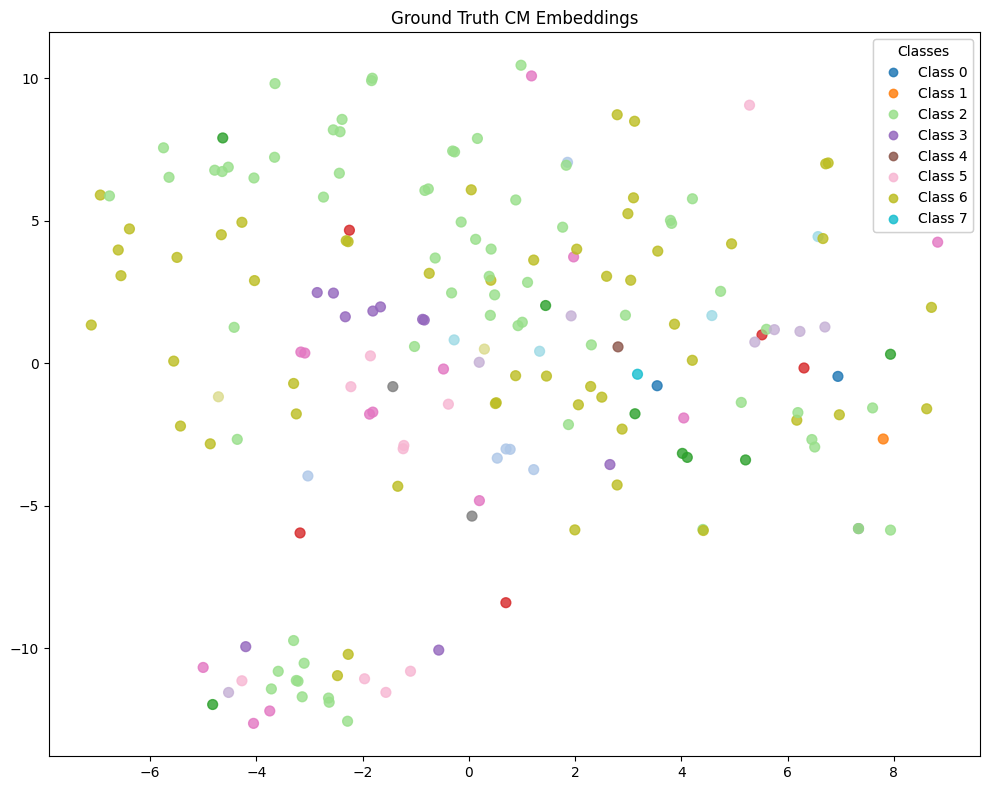

/tmp/ipykernel_745733/2291811602.py:16: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 16
  legend1 = plt.legend(handles=scatter.legend_elements()[0],


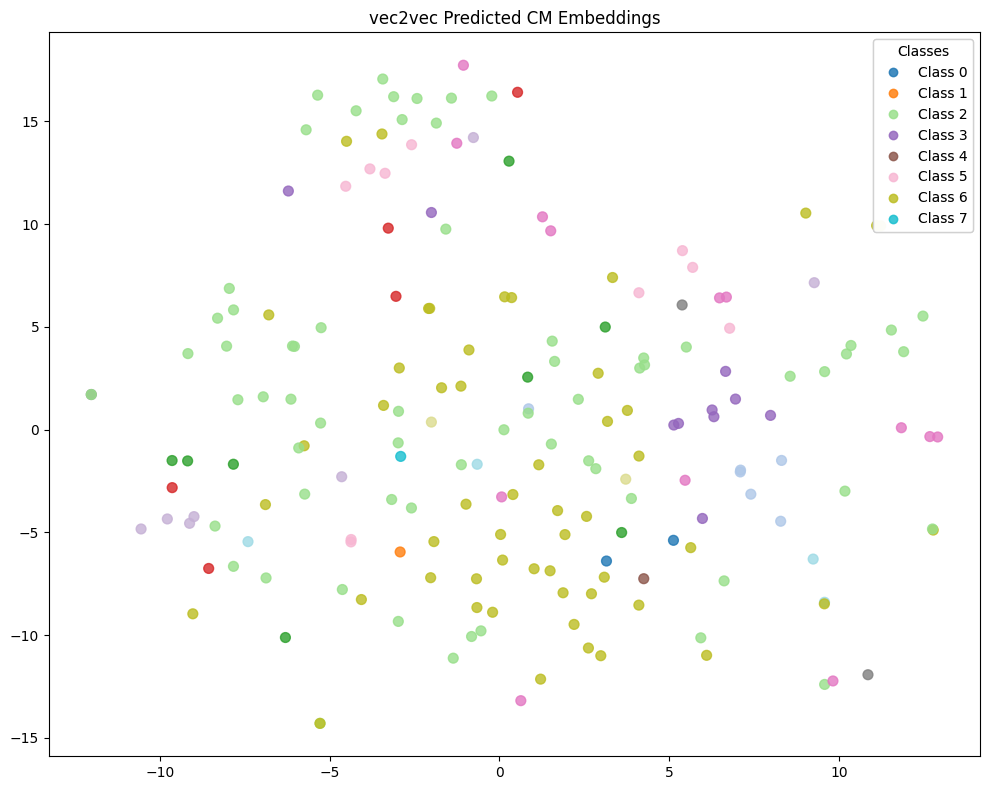

/tmp/ipykernel_745733/2291811602.py:16: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 16
  legend1 = plt.legend(handles=scatter.legend_elements()[0],


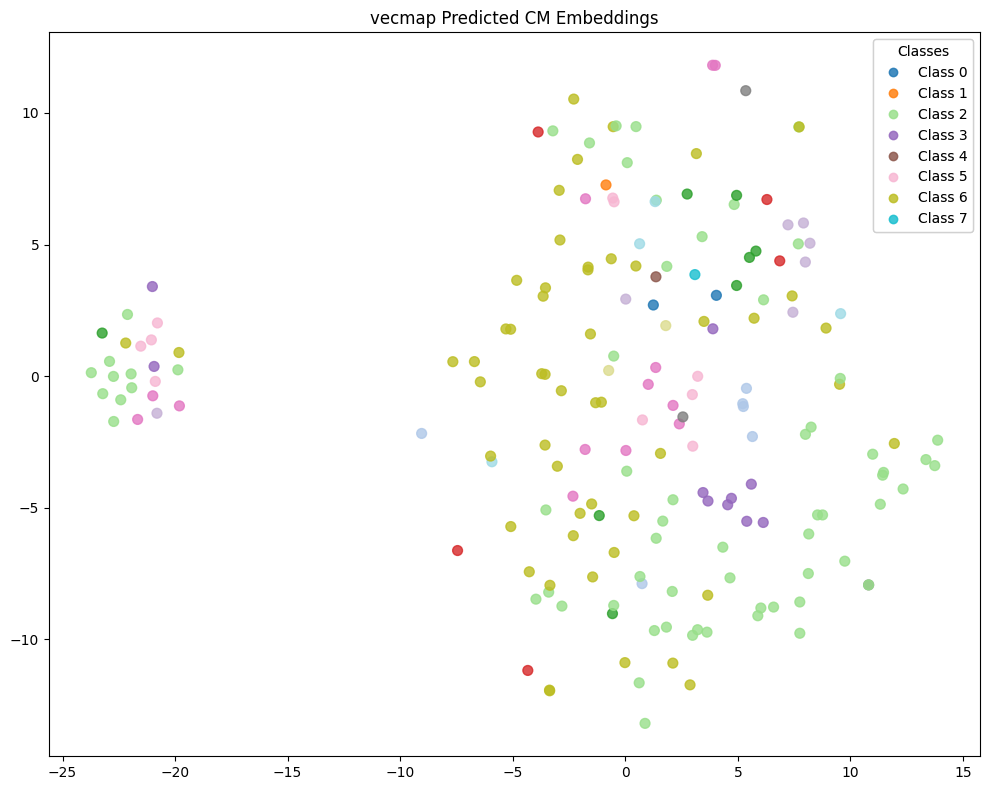

In [ ]:
# Visualize the clusters using t-SNE
from sklearn.manifold import TSNE

def plot_tsne_clusters(embeddings, labels, title):
    # Apply t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
    reduced_data = tsne.fit_transform(embeddings)
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, 
                          cmap='tab20', alpha=0.8, s=50)
    
    # Add a legend with class names
    class_names = [f"Class {i}" for i in range(n_clusters)]
    legend1 = plt.legend(handles=scatter.legend_elements()[0], 
                        labels=class_names,
                        title="Classes", loc="upper right")
    plt.gca().add_artist(legend1)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualize clusters for all embeddings
try:
    print("\nVisualizing clusters using t-SNE...")
    plot_tsne_clusters(Y, class_labels_encoded, "Ground Truth CM Embeddings")
    
    if 'vec2vec_pred' in locals():
        plot_tsne_clusters(vec2vec_pred, class_labels_encoded, "vec2vec Predicted CM Embeddings")
    
    if 'vecmap_pred' in locals():
        plot_tsne_clusters(vecmap_pred, class_labels_encoded, "vecmap Predicted CM Embeddings")
except Exception as e:
    print(f"Error creating t-SNE visualizations: {e}")

In [ ]:
from tqdm.auto import tqdm
import json


dataset_dir = 'datasets'
dataset_name = 'eamodelset'

data_path = os.path.join(dataset_dir, dataset_name, 'processed-models')
model_dirs = os.listdir(data_path)
archi_models = list()
for model_dir in tqdm(model_dirs, desc=f'Loading {dataset_name.title()}'):
    model_dir = os.path.join(data_path, model_dir)
    if os.path.isdir(model_dir):
        model_file = os.path.join(model_dir, 'model.json')
        if os.path.exists(model_file):
            # model = json.load(open(model_file))
            # archi_models.append(model)
            model_nl_str = serialize_model(model_file, stype='nl', model_type='archimate')
            model_cm_str = serialize_model(model_file, stype='cm', model_type='archimate')

Loading Eamodelset:   0%|          | 0/979 [00:00<?, ?it/s]

Model has the following elements: 
	Business Service
	Serviço de atendimento de suporte técnico ao cliente de software house
	Cliente tem problemas com o nosso sistema
	Atendimento ao cliente da software house
	Recepcionar o cliente
	Registra chamado
	Desenvolver solução
	Documentar a solução do problema
	Escalar o chamado para o cliente
	Notificar o cliente sobre a solução
	Chamado solucionado
	Coleta de opnião sobre o atendimento
	Avaliar com uma nota a satisfação do atendimento
	Chamado avaliado
	Atendente de suporte
	Programador
	Analista de Sistema
	DBA
	Analista de Redes
	Analista de segurança
	Analista de Operações
	Gerente de suporte
	Recepcionista de chamados
	Codifuicar novas aplicações
	Analista de suporte
	Mantenedor de programas existentes
	Designer de software
	Projetista de banco de dados
	Administrador de banco de dados
	Business Role
	Projetista de redes
	Administrador de redes existentes
	Administração de servidores em datacenter
	Operador de datacenter
	Administrador

In [ ]:
from serialization import serialize_archimate_models

serialize_archimate_models('datasets')

Loading Eamodelset:   0%|          | 0/980 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

df = pd.read_csv("datasets/eamodelset_serialized.csv")
df.columns

Index(['key', 'NL_Serialization', 'CM_Serialization'], dtype='object')

In [ ]:
from embed import add_embeddings

add_embeddings(df, ['NL_Serialization', 'CM_Serialization'], num_jobs=8, output_df_name="datasets/eamodelset_serialized_emb.csv")

Processing column: NL_Serialization


Generating embeddings:   0%|          | 0/978 [00:00<?, ?it/s]

Processing column: CM_Serialization


Generating embeddings:   0%|          | 0/978 [00:00<?, ?it/s]

In [ ]:
import pickle

with open("datasets/eamodelset_nl2cm_embedding.pkl", "rb") as f:
    df = pickle.load(f)

In [ ]:
import pandas as pd

df = pd.read_csv("datasets/eamodelset_serialized_emb.csv")

In [ ]:
import pandas as pd

df = pd.read_csv('datasets/bpmn_chunks/bpmn_chunk_01.csv')

In [ ]:
df.columns

Index(['Revision ID', 'Model ID', 'Organization ID', 'Datetime', 'Model JSON',
       'Description', 'Name', 'Type', 'Namespace'],
      dtype='object')

In [ ]:
import json


model_jsons = [json.loads(j) for j in df['Model JSON'].values]

In [ ]:
print(json.dumps(model_jsons[0], indent=4))

{
    "resourceId": "sid-afbe38d1-de27-4d76-9ced-898c8e16d0c5",
    "properties": {
        "title": "sid-afbe38d1-de27-4d76-9ced-898c8e16d0c5",
        "bpmn2_definitionsid": "sid-12515169-9613-4f11-aa19-99b3c7114379",
        "name": "",
        "documentation": "",
        "auditing": "",
        "monitoring": "",
        "flat": "",
        "version": "",
        "author": "",
        "language": "English",
        "targetnamespace": "http://www.signavio.com",
        "expressionlanguage": "http://www.w3.org/TR/XPath",
        "typelanguage": "http://www.w3.org/2001/XMLSchema",
        "creationdate": "",
        "modificationdate": "",
        "itemdefinitions": "",
        "signals": "",
        "exporter": "Signavio Process Editor, http://www.signavio.com",
        "exporterversion": "12.7.4",
        "defaultprocessname": "",
        "properties": "",
        "properties2": "",
        "datainputs": "",
        "dataoutputs": "",
        "inputsets": "",
        "outputsets": "

In [ ]:
def get_resources(node):
    
    def get_resources_util(n):
        if 'resourceId' in n:
            resources[n['resourceId']] = n
        if 'childShapes' in n and isinstance(n['childShapes'], list):
            for child in n['childShapes']:
                get_resources_util(child)
    
    resources = dict()
    get_resources_util(node)
    return resources

# resources = get_resources(model_jsons[0])

In [ ]:
def check_resource_presence(model, resources):    
    def check_resource_util(node):
        if 'outgoing' in model and len(model['outgoing']):
            for outgoing in model['outgoing']:
                assert outgoing['resourceId'] in resources, f"{outgoing['resourceId']} not in resources"
        
        if 'childShapes' in node and isinstance(model['childShapes'], list):
            for child in node['childShapes']:
                check_resource_util(child)
                
    check_resource_util(model)

# check_resource_presence(model_jsons[0], resources)

In [ ]:
def get_node_name(**kwargs):
    properties = kwargs.get('properties', {})
    level = kwargs.get('level')
    name = properties.get('name', '')
    description = f"{'\t'*(level)} is described by: {properties.get('documentation', '')}" if properties.get('documentation', '') else ""
    return f"{name}{description}"
    
def serialize_bpmn_nl_template(**kwargs):
    resource_map = kwargs.get('resource_map')
    level = kwargs.get('level')
    node_name = get_node_name(**kwargs)
    node_str = f"{'\t'*(level)}Node: {node_name}" if node_name else ""
    edges = kwargs.get('outgoing', [])
    edges_str= ""
    edges_content = [get_node_name(**resource_map[r['resourceId']]) for r in edges]
    edges_content = [e for e in edges_content if len(e)]
    if len(edges_content):
        edges_str = f"\n{'\t'*(level)}".join(edges_content)
    return f"{node_str}\n{'\t'*(level)}Connections:\n {edges_str}".strip()

def serialize_bpmn_cm_template(**kwargs):
    resource_map = kwargs.get('resource_map')
    node_type = kwargs.get('stencil')['id'] if 'stencil' in kwargs else ''
    level = kwargs.get('level')
    node_name = get_node_name(**kwargs)
    node_str = f"{'\t'*(level)}Node: ({node_type}) {node_name}" if node_name else ""
    edges = kwargs.get('outgoing', [])
    edges_str= ""
    edges_content = [get_node_name(level=level, **resource_map[r['resourceId']]) for r in edges]
    edges_content = [e for e in edges_content if len(e)]
    if len(edges_content):
        edges_str = f"\n{'\t'*(level)}".join(edges_content)
    return f"{node_str}\n{'\t'*(level)}Connections:\n {edges_str}".strip()

In [ ]:
from typing import Union, Literal


def serialize_bpmn(model, resources, stype=Union[Literal['cm', 'nl']], level=0):
    serializer = serialize_bpmn_cm_template if stype == 'cm' else serialize_bpmn_nl_template
    node_data = serializer(resource_map=resources, level=level, **model)
    child_data = list()
    if 'childShapes' in model and isinstance(model['childShapes'], list):
        for child in model['childShapes']:
            child_str = serialize_bpmn(child, resources, stype=stype, level=level+1)
            if child_str:
                child_data.append(child_str)
    
    data_str = f"{'\t'*level}{node_data}\n" + f"{'\t'*(level+1)}\n".join(child_data)
    return data_str

In [1]:
from serialization import serialize_bpmn_models

serialize_bpmn_models('datasets/bpmn_chunks')

Processing BPMN CSV chunks:   0%|          | 0/500 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1239 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1239 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1238 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1236 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1238 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1239 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1239 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1238 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1237 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1239 [00:00<?, ?it/s]

Serializing BPMN models:   0%|          | 0/1239 [00:00<?, ?it/s]

KeyboardInterrupt: 